In [1]:
# Setup - Import Libraries and Create Directories
import cv2
import numpy as np
import os

# Create necessary directories
os.makedirs('dataset/images', exist_ok=True)
os.makedirs('dataset/labels', exist_ok=True)
print("✅ Directories verified and ready: 'dataset/images/', 'dataset/labels/', 'dataset/videos/'")

✅ Directories verified and ready: 'dataset/images/', 'dataset/labels/', 'dataset/videos/'


In [2]:
# Define Dataset Generation Parameters
num_images = 50
height, width = 480, 640
lane_count = 3

print(f"Generating {num_images} images of size {width}x{height} with {lane_count} lanes.")

Generating 50 images of size 640x480 with 3 lanes.


In [3]:
# 🚗 Generate Simulated Images and Store Positions
image_positions = {}

for img_idx in range(1, num_images + 1):
    traffic_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Draw lane lines
    lane_width = width // lane_count
    for i in range(1, lane_count):
        cv2.line(traffic_image, (i * lane_width, 0), (i * lane_width, height), (255, 255, 255), 2)

    num_cars = np.random.randint(5, 10)
    car_positions = []  # Store positions to reuse in annotations

    for car_id in range(1, num_cars + 1):
        lane = np.random.randint(0, lane_count)
        x_start = lane * lane_width + np.random.randint(10, lane_width - 50)
        y_start = np.random.randint(30, height - 30)
        car_width = np.random.randint(30, 50)
        car_height = np.random.randint(20, 30)
        car_color = tuple(np.random.randint(50, 256, size=3).tolist())

        # Draw the car
        cv2.rectangle(traffic_image, (x_start, y_start), 
                      (x_start + car_width, y_start + car_height), 
                      car_color, -1)

        # Store positions for annotation generation
        car_positions.append((x_start, y_start, car_width, car_height))

    # Store car positions in a dictionary
    image_positions[f"traffic_{img_idx}"] = car_positions

    # Save image
    img_filename = f"traffic_{img_idx}.png"
    cv2.imwrite(f"dataset/images/{img_filename}", traffic_image)

print(f"\n✅ Successfully generated {num_images} images.")



✅ Successfully generated 50 images.


In [4]:
# 🏷️ Generate YOLO Annotations from Stored Positions
for img_idx in range(1, num_images + 1):
    label_filename = f"dataset/labels/traffic_{img_idx}.txt"
    yolo_annotations = []

    # Retrieve stored positions
    car_positions = image_positions.get(f"traffic_{img_idx}", [])

    for (x_start, y_start, car_width, car_height) in car_positions:
        class_id = 0  # 'car' class
        x_center = (x_start + car_width / 2) / width
        y_center = (y_start + car_height / 2) / height
        norm_width = car_width / width
        norm_height = car_height / height
        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")

    # Write labels to file
    with open(label_filename, 'w') as label_file:
        label_file.write('\n'.join(yolo_annotations))

print("✅ YOLO annotations generated for all images.")


✅ YOLO annotations generated for all images.


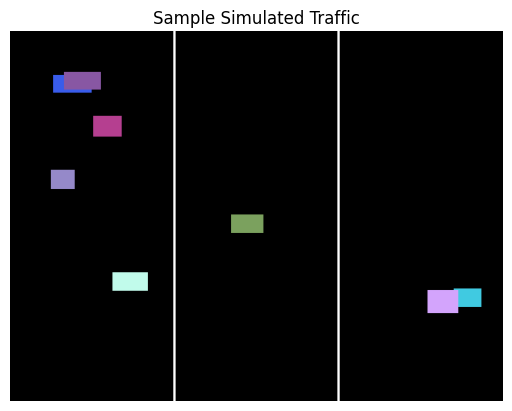

In [5]:
import matplotlib.pyplot as plt

# Load sample image
sample_img = cv2.imread("dataset/images/traffic_30.png")

# Convert BGR (OpenCV) to RGB for Matplotlib
sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

# Display
plt.imshow(sample_img_rgb)
plt.title("Sample Simulated Traffic")
plt.axis('off')
plt.show()

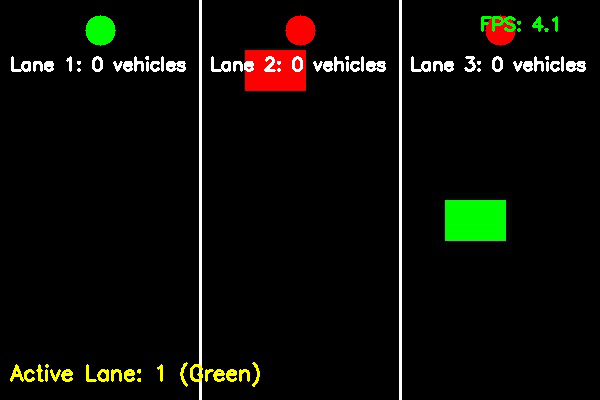

✅ Processing complete!


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [6]:
import cv2
import numpy as np
from ultralytics import YOLO
import time
import os
from IPython.display import display, clear_output
import PIL.Image
import io

# Debug Check 1: Verify Model File Exists
MODEL_PATH = 'yolov8n.pt'
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"❌ Error: YOLO model not found at {MODEL_PATH}")

# Load YOLOv8 model
model = YOLO(MODEL_PATH)

# Debug Check 2: Verify Video File Exists
VIDEO_PATH = 'dataset/videos/simulated_traffic_video.avi'
if not os.path.exists(VIDEO_PATH):
    raise FileNotFoundError(f"❌ Error: Video file not found at {VIDEO_PATH}")

# Load video
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"❌ Error: Cannot open video at {VIDEO_PATH}")

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 30  # Default to 30 if FPS is zero
lane_width = frame_width // 3

# Output video writer
OUTPUT_PATH = 'dataset/videos/ai_traffic_signal_output.avi'
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (frame_width, frame_height))

if not out.isOpened():
    raise RuntimeError("❌ Error: Cannot write output video!")

print(f"🚦 Smart Traffic Signal started... Processing frames...")

# Define vehicle classes of interest (YOLO class IDs)
vehicle_classes = {2, 3, 5, 7}  # Car, Motorcycle, Bus, Truck

# Signal color mapping
signal_colors = {
    'Green': (0, 255, 0),
    'Yellow': (0, 255, 255),
    'Red': (0, 0, 255)
}

# Function to show frame inside Jupyter Notebook
def show_frame(frame):
    _, buffer = cv2.imencode('.jpg', frame)
    display(PIL.Image.open(io.BytesIO(buffer)))

# Start processing
frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        print("✅ Processing complete!")
        break

    frame_count += 1
    start_time = time.time()

    # Debug Check 3: Ensure Frame is Read Correctly
    if frame is None:
        print(f"❌ Error: Frame {frame_count} is empty! Skipping...")
        continue

    # YOLOv8 inference with lower confidence threshold
    results = model(frame, conf=0.25, verbose=False)[0]

    # Debug Check 4: Print detected objects
    num_objects = len(results.boxes) if results.boxes else 0
    print(f"Frame {frame_count}: ✅ {num_objects} objects detected.")

    # Initialize lane vehicle counts
    lane_counts = [0, 0, 0]

    # Count vehicles per lane
    for box in results.boxes:
        cls = int(box.cls[0])
        if cls in vehicle_classes:
            x1, _, x2, _ = map(int, box.xyxy[0])
            cx = (x1 + x2) // 2
            lane_idx = min(cx // lane_width, 2)  # Ensures lane index stays within range
            lane_counts[lane_idx] += 1

    # Decision: assign signal based on vehicle counts
    max_lane = np.argmax(lane_counts)
    lane_signals = ['Red', 'Red', 'Red']
    lane_signals[max_lane] = 'Green'

    # Draw lane lines
    cv2.line(frame, (lane_width, 0), (lane_width, frame_height), (255, 255, 255), 2)
    cv2.line(frame, (2 * lane_width, 0), (2 * lane_width, frame_height), (255, 255, 255), 2)

    # Draw signal lights and text for each lane
    for i in range(3):
        cx = lane_width * i + lane_width // 2
        cv2.circle(frame, (cx, 30), 15, signal_colors[lane_signals[i]], -1)
        cv2.putText(frame, f"Lane {i+1}: {lane_counts[i]} vehicles", (lane_width * i + 10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Overlay global status
    overlay_text = f"Active Lane: {max_lane+1} ({lane_signals[max_lane]})"
    cv2.putText(frame, overlay_text, (10, frame_height - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

    # FPS Calculation
    elapsed_time = time.time() - start_time
    fps_val = 1 / elapsed_time if elapsed_time > 0 else 0
    cv2.putText(frame, f"FPS: {fps_val:.1f}", (frame_width - 120, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Save frame
    out.write(frame)

    # Display frame in Jupyter Notebook (comment out if running outside Jupyter)
    clear_output(wait=True)  # Clears previous frame to prevent flickering
    show_frame(frame)

cap.release()
out.release()
cv2.destroyAllWindows()
print(f"✅ Detection complete. Output saved to: {OUTPUT_PATH}")
